In [17]:
# Import necessary modules
import geopandas as gpd
from shapely.geometry import Polygon, mapping
import json
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO
from PIL import Image
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import math as mth

from helper_functions import cart_to_polar, get_intersection
from data_processing import load_data, plot_data, get_left_and_right_bound, trim_datasets
from helper_functions import get_area, get_distance


In [24]:
file_path = r"C:\Users\Eric.Englin\DOT OST\VIEW - MassDOT\Data Collection\\"

In [31]:
markerless_data = pd.read_excel(file_path + "MassDOT Markerless data.xlsx")

In [32]:
def calculate_area(coordinates):
    # Code adapted from https://stackoverflow.com/questions/41077185/fastest-way-to-shoelace-formula
    x = coordinates[:, 0]
    y = coordinates[:, 1]

    S1 = np.sum(x * np.roll(y, -1))
    S2 = np.sum(y * np.roll(x, -1))

    area = .5 * np.absolute(S1 - S2)

    return area

In [33]:
def viz_overhead(nvp_x_cartesian, nvp_y_cartesian, eye_height_full, 
                 eye_point_full, vru_selected, vehicle_width, vehicle_D, dist_to_pass_window):
    '''
    Takes NVPs, vehicle measurements, and VRU. Plots overhead view of blind zone
      with nearest forward-visible VRU. Saves the figure as an SVG and returns fig
       for viewing, if desired.

    Takes inputs:
    vp_x_cartesian = np.array([nums]) [cm]
    nvp_y_cartesian = np.array([nums]) [cm]
    # eye height calculated from interpolated seat-ground [m]
    eye_height_full = num
    eye_point_full = num # interpolated front-of-hood to eye distance
      interpolated [m]
    vru_selected = array # options: 1=toddler, 2=elementary, 3=elem_bike,
      4=wheelchair, 5=adult_bike, 6=adult

    *np.array requires importing the numpy library (import numpy as np)
    '''
    '''VRU sizes (taken fron VIEW 1.0)
      'pre-school', 'elem_bike', 'elementary', 'wheelchair', 'adult_bike', 'adult'
      shoulder height, width, person height (all in [in])
      DOESN'T CONTAIN DEPTH, BUT ASSUMES THAT BICYCLES ARE 4X DEPTH OF PEOPLE AND IGNORES WHEELCHAIRS?'''
    vru_label = ['pre-school child', 'elementary schooler on bike', 'elementary school child',
                 'wheelchair user', 'adult on bike', 'adult']
    vru_sizes = np.array([[28, 9, 34], [35, 12, 45], [37, 12, 45], [
                         39, 26, 49], [47, 16, 58], [49, 16, 60]])
    # vru depths in inches (4ft for bikes, 2ft for wheelchair, and 1ft for anything else)
    vru_depths = np.array([12, 48, 12, 24, 48, 12])
    # vru areas in square feet
    vru_areas = (vru_sizes[:, 1] / 12) * (vru_depths / 12)

    max_distance = 7*7  # maximum distance plotted (multiple of 7)

    # start and end angles for plotting [deg]
    plot_start = -0
    plot_end = 180

    # background colors (make sure to have the same number of colors as plot divisions)
    greenBG = ['#143A1D', '#1A5A2D', '#1F723A',
               '#429344', '#7CBC55', '#A6C991', '#CAE4BB']

    ''' -------------------------
  Begin initial data processing
  --------------------------'''
    # convert vehicle measurements from [m] to [ft]
    eye_height_full = eye_height_full*3.28084
    eye_point_full = eye_point_full*3.28084
    dist_to_pass_window = dist_to_pass_window*3.28084
    
    print(eye_height_full)
    print(eye_point_full)

    # convert NVP data from [cm] to [ft]
    nvp_x_cartesian_ft = np.asarray(nvp_x_cartesian)*0.032808399
    nvp_y_cartesian_ft = np.asarray(nvp_y_cartesian)*0.032808399

    # convert to polar coordinate system
    r = np.sqrt(np.square(nvp_x_cartesian_ft) + np.square(nvp_y_cartesian_ft))
    theta = np.arctan2(nvp_y_cartesian_ft, nvp_x_cartesian_ft)

    # sort data from smallest to largest theta value ('untwist') (WIP)
    '''idx = np.argsort(theta)  # find indices that would sort the array
    r_sorted = np.array(r)[idx]
    theta_sorted = np.array(theta)[idx]'''
    r_sorted = r
    theta_sorted = theta
    
   # print("r", r_sorted)
  #  print("theta", theta_sorted)

    ''' -----------------------
    End initial data processing
    ------------------------'''

    """
    ------------------------------------
    Begin Calculate Area Taken Up By Car
    ------------------------------------
    """
    # calculate vehicle area in [ft^2]
    vehicle_width = vehicle_width*3.28084
    
    print("vehicle_width", vehicle_width)
    print("eye_point_full", eye_point_full)
    
    vehicle_area = vehicle_width * eye_point_full
    print("vehicle_area", vehicle_area)
  
    #vehicle_area = (vehicle_width * eye_point_full) + (vehicle_D**2 * mth.tan(mth.radians(20)
     #                                            ) / 2) + ((vehicle_width - vehicle_D)**2 * mth.tan(mth.radians(20)) / 2)
  #  print(vehicle_area)
    # initialize array to hold areas bounded by nvps and each vru in [ft^2]
    vru_nvp_areas = []
    # initialize array to hold number of vrus in the vru_nvp_areas
    num_vrus_in_vru_nvp_area = []
    # initialize array to hold closest forward vru
    closest_forward_vrus = []
    closest_passenger_vrus = []
    
    # use nvps for first area
    ground_points = np.stack(
        (r_sorted * np.cos(theta_sorted), r_sorted * np.sin(theta_sorted)), axis=1)
    ground_area = calculate_area(np.append(ground_points, [[0, 0]], axis=0))
    print("ground_area", ground_area)
    vru_nvp_areas.append(max(0, ground_area - vehicle_area))
    print("vru_nvp_areas", vru_nvp_areas)
    """
    ----------------------------------
    End Calculate Area Taken Up By Car
    ----------------------------------
    """

    # set figure size (check as regular script since notebooks don't work the same way)
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig, ax = plt.subplots(
        subplot_kw={'projection': 'polar'}, figsize=(800*px, 600*px))

    # plot background arcs
    for i in range(0, 7):
        colorBG = greenBG[i]
        ax.bar(np.pi/2, max_distance/7, width=mth.radians(plot_end-plot_start), bottom=i*max_distance/7,
               color=colorBG, edgecolor=colorBG, label='_Visible Zone')  # 294 previously max(r)

    # plot NVPs
    ax.plot(theta_sorted, r_sorted, '#404040',
            linewidth=0)
    ax.set_rlabel_position(-20)  # Move radial labels away from plotted line
    # 65% opacity (a6) 5c5c5ca6 is lighter bf
    ax.fill(theta_sorted, r_sorted, '#404040', label="ground blindzone")

    # set plot color options based on number of VRUs so ligher color is always on top
    if len(vru_selected) == 2:
        vru_plot_colors = ['#A34D9D', '#A6DDE7']
        vru_fill_colors = ['#A34D9Da6', '#A6DDE7a6']
    else:
        vru_plot_colors = ['#A6DDE7']
        vru_fill_colors = ['#A6DDE7a6']
    graph_str = ['', '']
    vru_index = 0
    for vru in vru_selected:
        ''' --------------------------------------
      Begin calculate NVPs for seeing vru_selected
      -----------------------------------------'''

        # store 'shoulder height' of selected VRU in [ft]
        vru_height = vru_sizes[vru-1, 0]/12
        # store 'width' of selected VRU in [ft]
        vru_width = vru_sizes[vru-1, 1]/12

        r_vru_nvp = np.empty(len(r_sorted))

        for i in range(len(theta_sorted)):
            # find sides of triangle from eye to ground
            b_eye = r_sorted[i]  # length
            a_eye = eye_height_full  # height
            c_eye = mth.sqrt(a_eye**2 + b_eye**2)  # hypotenuse

            # find sides of similar triangle from vru to ground
            a_vru = vru_height  # height
            c_vru = (a_vru*c_eye)/a_eye  # hypotenuse (similar triangles)
            b_vru = mth.sqrt(c_vru**2 - a_vru**2)  # length, this is incorrect in the current VIEW app 2.0 code

            r_vru_nvp[i] = b_eye-b_vru  # find distance from eye to visible vru

        # add area of vru to area array
        # replace all NVPs greater than max distance with the max distance
        r_area_calc = np.copy(r_vru_nvp)
        r_area_calc[r_area_calc > max_distance] = max_distance
        vru_points = np.stack(
            (r_area_calc * np.cos(theta_sorted), r_area_calc * np.sin(theta_sorted)), axis=1)
        vru_area = calculate_area(np.append(vru_points, [[0, 0]], axis=0))
        print("vru_area", vru_area)
        vru_nvp_areas.append(max(0, vru_area - vehicle_area))
        print("vru_areas[vru - 1]", vru_areas[vru - 1])
        print("vru_area", vru_area)
        print("vehicle_area", vehicle_area)
        print("int(max(0, vru_area - vehicle_area) / vru_areas[vru - 1])", int(max(0, vru_area - vehicle_area) / vru_areas[vru - 1]))
        num_vrus_in_vru_nvp_area.append(
            int(max(0, vru_area - vehicle_area) / vru_areas[vru - 1]))
        
        print(num_vrus_in_vru_nvp_area)

        # plot effective NVP to vru
        ax.plot(theta_sorted, r_vru_nvp,
                vru_plot_colors[vru_index], linewidth=1)
        ax.fill(theta_sorted, r_vru_nvp, vru_fill_colors[vru_index],
                label=f"{vru_label[vru-1]} blindzone")
        ''' ------------------------------------
      End calculate NVPs for seeing vru_selected
      ---------------------------------------'''
        ''' ---------------------------------------------------------
      Begin note minimum distance from hood to VRU in front of driver
      ------------------------------------------------------------'''
        # find nvp in front of driver (with tolerance)
        # b/w 88 and 92deg (taking ind0 since returns array inside variable)
        front_range_indices = np.where(np.logical_and(
            theta_sorted >= (mth.pi/2)-mth.radians(2),
            theta_sorted <= (mth.pi/2)+mth.radians(2)))[0]
        # find index of minimum of selected entries
        front_r_min_index = front_range_indices[np.argmin(
            r_sorted[front_range_indices])]
        print("r_sorted", r_sorted[front_range_indices])
        print("r_sorted_min", r_sorted[front_r_min_index])
        print("r_vru_nvp", r_vru_nvp[front_r_min_index])
        # store r value that meets the conditions above (absolute location)
        r_vru_fit = r_vru_nvp[front_r_min_index]
        print(f"distance from eye to bumper: {eye_point_full}")
        print(f"distance from eye to {vru_label[vru-1]}: {r_vru_fit}")
        # minimum distance from HOOD to first visible VRU in front of driver (relative distance)
        front_vru_dist = r_vru_fit-eye_point_full  # [ft]
        if front_vru_dist < 0:  # prevent negativ results
            front_vru_dist = 0
        # print(f"distance from hood to {vru_label[vru-1]}: {front_vru_dist}")
        # store note (str) of distance to closest forward-visible VRU to pass to site
      #  graph_str[vru_index] = ('The closest forward-visible ' +
      #                          vru_label[vru-1] + ' is ' +
      #                          str(round(front_vru_dist,2)) + 'ft in front of the vehicle.')
        print('The closest forward-visible ' +
                                vru_label[vru-1] + ' is ' +
                                str(round(front_vru_dist,2)) + 'ft in front of the vehicle.')
        closest_forward_vrus.append(round(front_vru_dist,2))
      #   ''' -------------------------------------------------------
      # End note minimum distance from hood to VRU in front of driver
      # ----------------------------------------------------------'''
        ''' ---------------------------------------------------------
      Begin note minimum distance from eyepoint to VRU on passenger side
      ------------------------------------------------------------'''
        # find nvp in passenger side of driver (with tolerance)
        # b/w 0 and 2 deg (taking ind0 since returns array inside variable)
        passenger_range_indices = np.where(np.logical_and(
            theta_sorted >= 0,
            theta_sorted <= mth.radians(2)))[0]
        # find index of minimum of selected entries
        passenger_r_min_index = passenger_range_indices[np.argmin(
            r_sorted[passenger_range_indices])]
        print("r_sorted_passenger", r_sorted[passenger_range_indices])
        print("r_sorted_min_passenger", r_sorted[passenger_r_min_index])
        print("r_vru_nvp_passenger", r_vru_nvp[front_r_min_index])
        # store r value that meets the conditions above (absolute location)
        r_vru_fit = r_vru_nvp[passenger_r_min_index]
        print(f"distance from eye to passenger window: {dist_to_pass_window}")
        print(f"distance from eye to {vru_label[vru-1]}: {r_vru_fit}")
        # minimum distance from HOOD to first visible VRU in front of driver (relative distance)
        passenger_vru_dist = r_vru_fit-dist_to_pass_window  # [ft]
        if passenger_vru_dist < 0:  # prevent negativ results
            passenger_vru_dist = 0
        # print(f"distance from hood to {vru_label[vru-1]}: {front_vru_dist}")
        # store note (str) of distance to closest forward-visible VRU to pass to site
    #    graph_str[vru_index] = ('The closest forward-visible ' +
    #                            vru_label[vru-1] + ' is ' +
    #                            str(round(front_vru_dist,2)) + 'ft in front of the vehicle.')
        print('The closest passenger side-visible ' +
                                vru_label[vru-1] + ' is ' +
                                str(round(passenger_vru_dist,2)) + 'ft to the side of the vehicle.')
        closest_passenger_vrus.append(round(passenger_vru_dist,2))
      #   ''' -------------------------------------------------------
      # End note minimum distance from hood to VRU in front of driver
      # ----------------------------------------------------------'''
        graph_str[vru_index] = " "
        vru_index += 1

    # restrict angles of plot (switching min and max moves tick labels)
    ax.set_thetamin(plot_end)
    ax.set_thetamax(plot_start)

    # make plot axes match background divisions
    # generate markers range(0,round(max(r)),round(max(r)/7))
    tick_list = np.arange(0, max_distance+1, max_distance/7)
    ax.set_ylim(0, max_distance)  # [0,round(max(r))]
    plt.yticks(tick_list)  # range(0,round(max(r)),round(max(r)/7))

    # label the radial axis
    label_position = ax.get_rlabel_position()
    ax.text(np.radians(plot_end + 12), 5 + ax.get_rmax()/2., 'Distance from Driver Eye [ft]',
             horizontalalignment='right', ha='center', va='center')

    ax.grid(True, color='#fff')
    ax.spines['polar'].set_visible(False)



    # legend in bottom left corner of FIGURE, not PLOT
    # fig.legend(loc='lower right', fontsize="12", fancybox=False)

    # title for the graph
    '''plt.title(
        f"Blindzones for {height_percentile} Driver in {vehicle}", fontsize=15)'''

    #imgdata = StringIO()
    # save file as SVG
    # plt.savefig('/content/viz_overhead.svg', transparent=False, dpi='figure',
    #             pad_inches=0, facecolor='#fff', edgecolor='#5c5c5c')
   # fig.savefig(imgdata, format='svg', transparent=False, dpi='figure',
          #      pad_inches=0, facecolor='#fff', edgecolor='#5c5c5c')

   # imgdata.seek(0)

   # data = imgdata.getvalue()

   # return data, closest_forward_vrus, num_vrus_in_vru_nvp_area
    return closest_forward_vrus, closest_passenger_vrus, num_vrus_in_vru_nvp_area


5.1837272
7.709974
vehicle_width 5.6102364
eye_point_full 7.709974
vehicle_area 43.2547767778536
ground_area 1326.2641916550492
vru_nvp_areas [1283.0094148771957]
vru_area 401.0102905380081
vru_areas[vru - 1] 0.75
vru_area 401.0102905380081
vehicle_area 43.2547767778536
int(max(0, vru_area - vehicle_area) / vru_areas[vru - 1]) 477
[477]
r_sorted [22.37729604 22.49235449 22.51617956 22.54023544 22.57728314]
r_sorted_min 22.37729604425533
r_vru_nvp 12.3046805775446
distance from eye to bumper: 7.709974
distance from eye to pre-school child: 12.3046805775446
The closest forward-visible pre-school child is 4.59ft in front of the vehicle.
r_sorted_passenger [17.97244097]
r_sorted_min_passenger 17.97244097259111
r_vru_nvp_passenger 12.3046805775446
distance from eye to passenger window: 3.9041995999999997
distance from eye to pre-school child: 9.882567801272874
The closest passenger side-visible pre-school child is 5.98ft to the side of the vehicle.


([4.59], [5.98], [477])

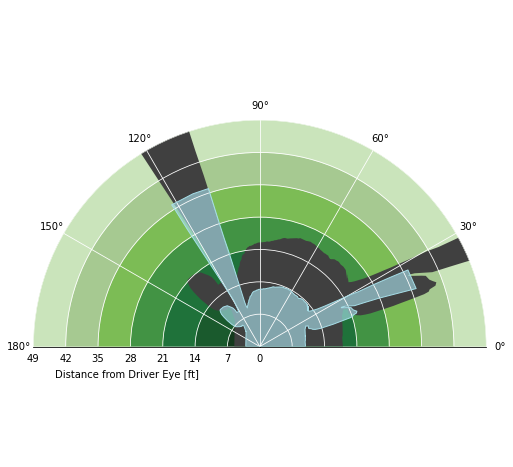

In [34]:
# try running on Volpe van 
suburban = "Data/Suburban 2006.shp"

# Read file using gpd.read_file()
data = gpd.read_file(suburban)
poly_mapped = mapping(data)
poly_coordinates = poly_mapped['features'][0]['geometry']['coordinates'][0]
#coords = [coords[0,1] for coords in poly_coordinates]
lats = [coords[1] for coords in poly_coordinates]
lons = [coords[0] for coords in poly_coordinates]

df = pd.DataFrame({
    'lat':lats,
    'lon':lons})

eye_height_full = 1.58
eye_point_full = 2.35
vru_selected=[1,3]
vehicle_width = 1.19+.52
dist_to_passenger_window = 1.19
vehicle_D = 1

viz_overhead(df.lon*100, df.lat*100, eye_height_full, 
                 eye_point_full, [1], vehicle_width, vehicle_D, dist_to_passenger_window)

C:\Users\Eric.Englin\DOT OST\VIEW - MassDOT\Data Collection\shapefiles/Ford_F450_2015__10m.shp
5.6758532
-8.694226
vehicle_width 6.397637999999999
eye_point_full -8.694226
vehicle_area -55.62251063818799
ground_area 1028.8572066307852
vru_nvp_areas [1084.4797172689732]
vru_area 356.8130992020815
vru_areas[vru - 1] 0.75
vru_area 356.8130992020815
vehicle_area -55.62251063818799
int(max(0, vru_area - vehicle_area) / vru_areas[vru - 1]) 549
[549]
r_sorted [26.83046487 26.4295604  27.22985902 26.92583497 27.32639694 27.45928903
 27.22918539 27.46966439]
r_sorted_min 26.429560399459525
r_vru_nvp 15.564414298534018
distance from eye to bumper: -8.694226
distance from eye to pre-school child: 15.564414298534018
The closest forward-visible pre-school child is 24.26ft in front of the vehicle.
r_sorted_passenger [20.39419324 20.58398953]
r_sorted_min_passenger 20.39419323756976
r_vru_nvp_passenger 15.564414298534018
distance from eye to passenger window: 3.9041995999999997
distance from eye to p

vru_area 48.6659078058841
vru_areas[vru - 1] 1.3333333333333333
vru_area 48.6659078058841
vehicle_area -54.83566873636864
int(max(0, vru_area - vehicle_area) / vru_areas[vru - 1]) 77
[77]
r_sorted [25.01172655 25.00793699 25.01481495]
r_sorted_min 25.007936985628554
r_vru_nvp 5.912920190341914
distance from eye to bumper: -8.3989504
distance from eye to adult: 5.912920190341914
The closest forward-visible adult is 14.31ft in front of the vehicle.
r_sorted_passenger [18.07902997]
r_sorted_min_passenger 18.07902997118666
r_vru_nvp_passenger 5.912920190341914
distance from eye to passenger window: 3.9041995999999997
distance from eye to adult: 4.274637344130342
The closest passenger side-visible adult is 0.37ft to the side of the vehicle.
C:\Users\Eric.Englin\DOT OST\VIEW - MassDOT\Data Collection\shapefiles/Elgin_Eagle_2012_10m.shp
7.874015999999999
-8.431758799999999
vehicle_width 7.5131236
eye_point_full -8.431758799999999
vehicle_area -63.34884602978767
ground_area 882.1110944810644
v

C:\Users\Eric.Englin\AppData\Local\Temp\ipykernel_22040\827641009.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(


vru_area 71.68347035796505
vru_areas[vru - 1] 1.3333333333333333
vru_area 71.68347035796505
vehicle_area -53.38899908377601
int(max(0, vru_area - vehicle_area) / vru_areas[vru - 1]) 93
[93]
r_sorted [30.3377547]
r_sorted_min 30.337754695614738
r_vru_nvp 7.453895128406064
distance from eye to bumper: -8.1364832
distance from eye to adult: 7.453895128406064
The closest forward-visible adult is 15.59ft in front of the vehicle.
r_sorted_passenger [20.84186355]
r_sorted_min_passenger 20.841863548304897
r_vru_nvp_passenger 7.453895128406064
distance from eye to passenger window: 3.9041995999999997
distance from eye to adult: 5.120783219730818
The closest passenger side-visible adult is 1.22ft to the side of the vehicle.
C:\Users\Eric.Englin\DOT OST\VIEW - MassDOT\Data Collection\shapefiles/Ford_F650_2016_10m.shp
6.9553808
-9.4816276
vehicle_width 6.56168
eye_point_full -9.4816276
vehicle_area -62.21540619036799
ground_area 1144.9667181287423
vru_nvp_areas [1207.1821243191102]
vru_area 505.61

r_sorted [17.6958503  17.52309498 17.44540457]
r_sorted_min 17.445404567477123
r_vru_nvp 7.626417515467187
distance from eye to bumper: -6.725721999999999
distance from eye to wheelchair user: 7.626417515467187
The closest forward-visible wheelchair user is 14.35ft in front of the vehicle.
r_sorted_passenger [22.56069557]
r_sorted_min_passenger 22.560695573156657
r_vru_nvp_passenger 7.626417515467187
distance from eye to passenger window: 3.9041995999999997
distance from eye to wheelchair user: 9.86261357337654
The closest passenger side-visible wheelchair user is 5.96ft to the side of the vehicle.
5.7742784
-6.725721999999999
vehicle_width 6.4960632
eye_point_full -6.725721999999999
vehicle_area -43.690715177630395
ground_area 619.3995295176678
vru_nvp_areas [663.0902446952982]
vru_area 64.10402870045675
vru_areas[vru - 1] 5.333333333333333
vru_area 64.10402870045675
vehicle_area -43.690715177630395
int(max(0, vru_area - vehicle_area) / vru_areas[vru - 1]) 20
[20]
r_sorted [17.6958503

8.2021
-8.3989504
vehicle_width 7.742782399999999
eye_point_full -8.3989504
vehicle_area -65.03124533559296
ground_area 1173.9484868655927
vru_nvp_areas [1238.9797322011857]
vru_area 487.4837229574364
vru_areas[vru - 1] 4.0
vru_area 487.4837229574364
vehicle_area -65.03124533559296
int(max(0, vru_area - vehicle_area) / vru_areas[vru - 1]) 138
[138]
r_sorted [31.61204499 32.17432754]
r_sorted_min 31.612044992354807
r_vru_nvp 20.37080215279321
distance from eye to bumper: -8.3989504
distance from eye to elementary schooler on bike: 20.37080215279321
The closest forward-visible elementary schooler on bike is 28.77ft in front of the vehicle.
r_sorted_passenger [32.808399]
r_sorted_min_passenger 32.808399
r_vru_nvp_passenger 20.37080215279321
distance from eye to passenger window: 3.9041995999999997
distance from eye to elementary schooler on bike: 21.141732688933324
The closest passenger side-visible elementary schooler on bike is 17.24ft to the side of the vehicle.
8.2021
-8.3989504
vehic

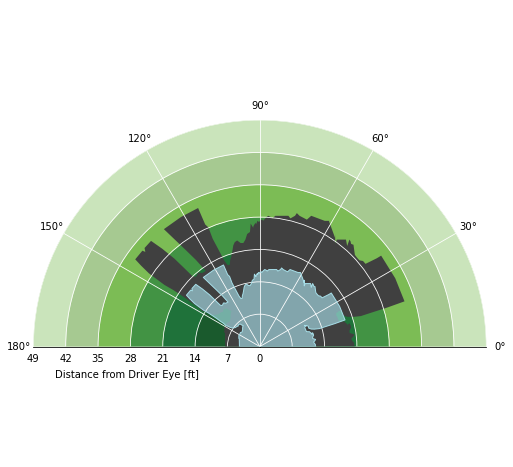

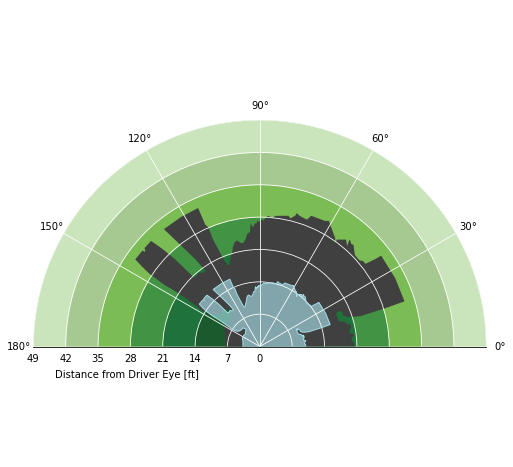

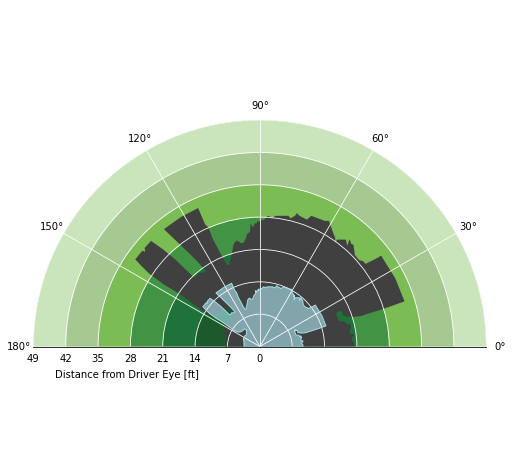

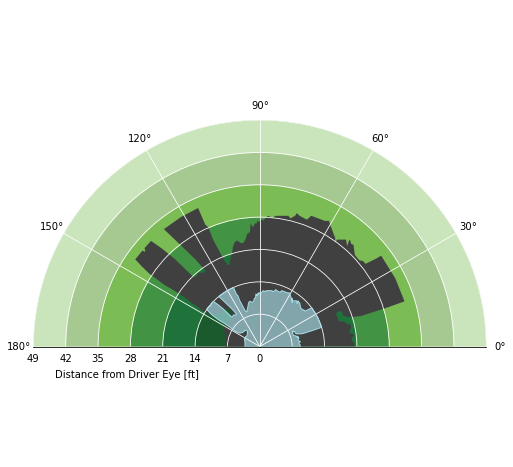

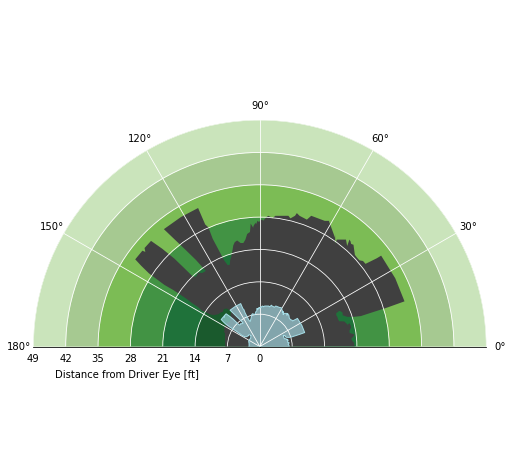

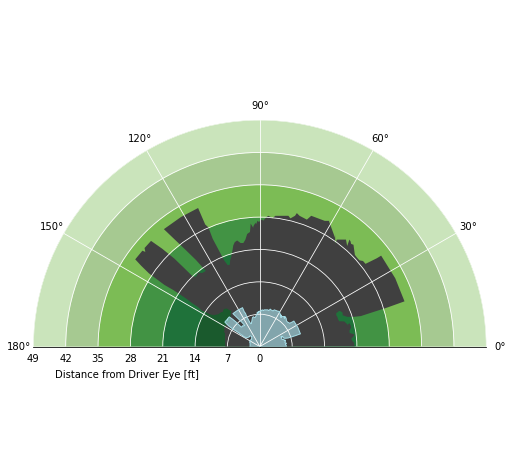

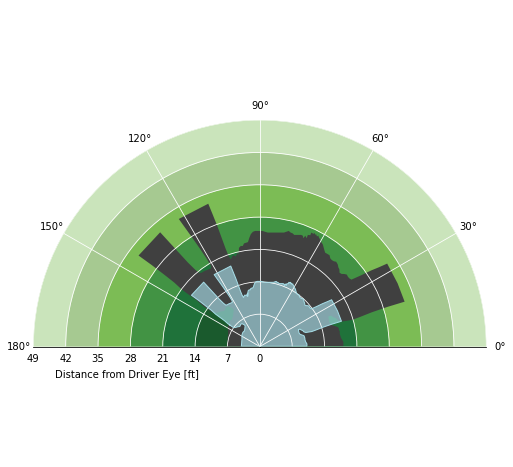

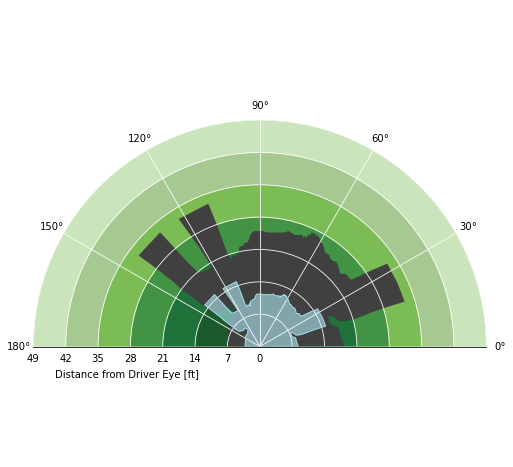

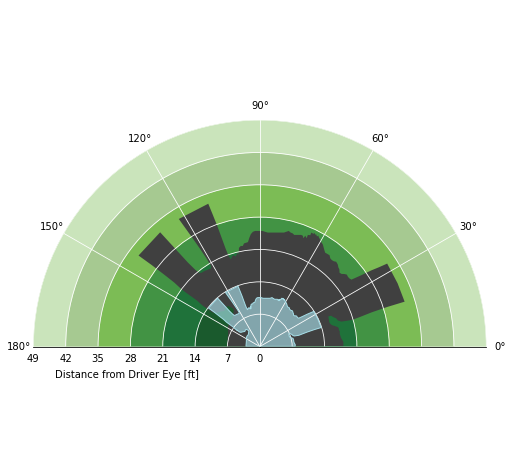

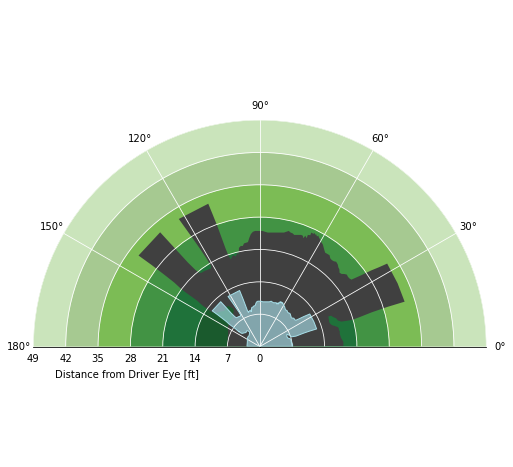

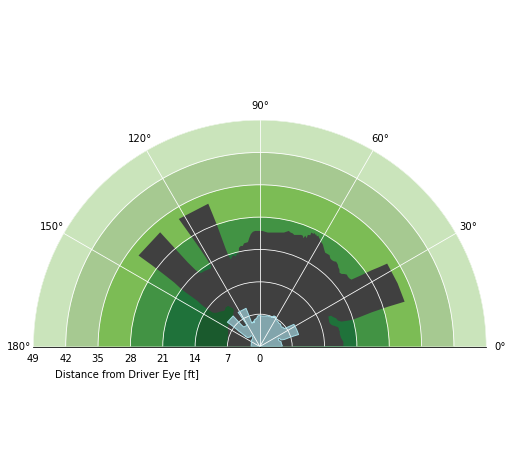

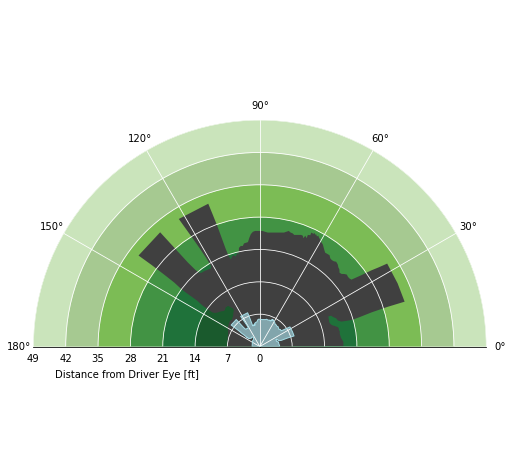

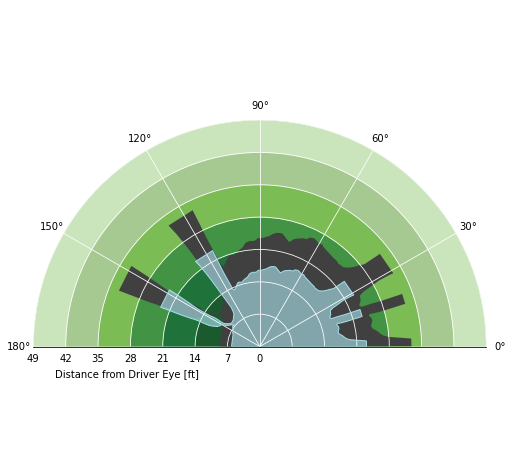

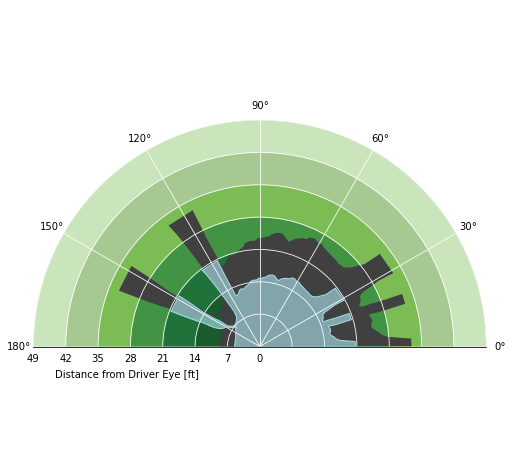

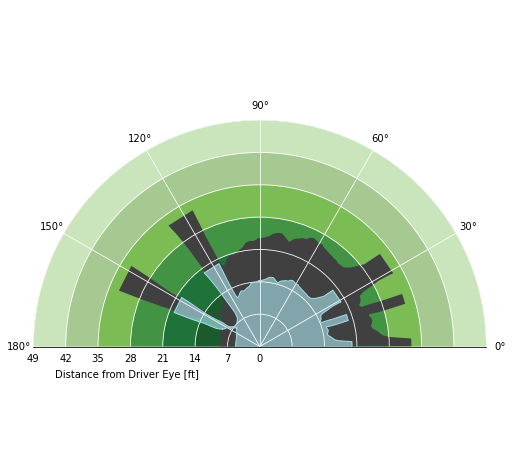

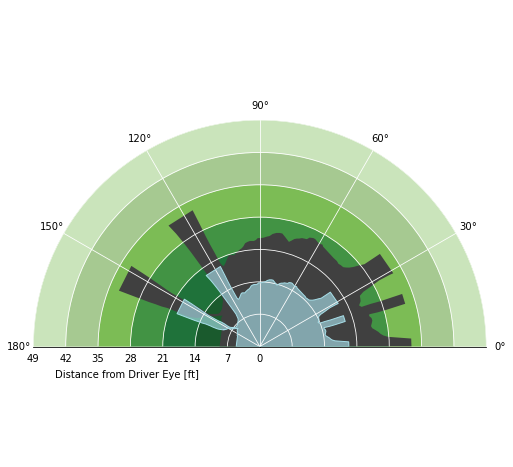

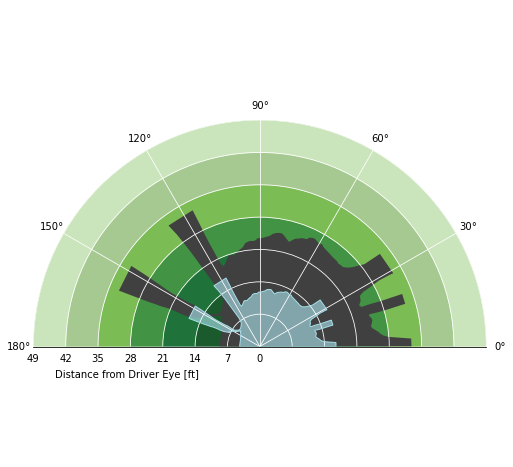

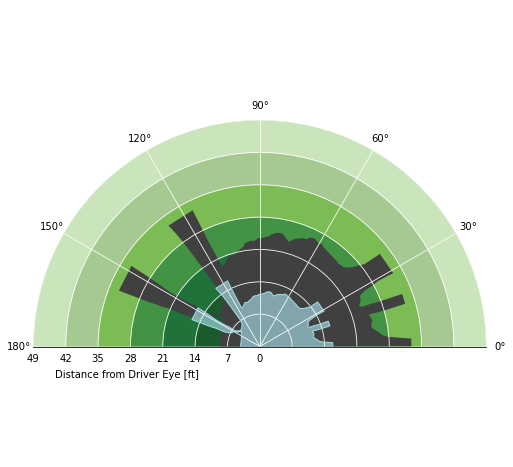

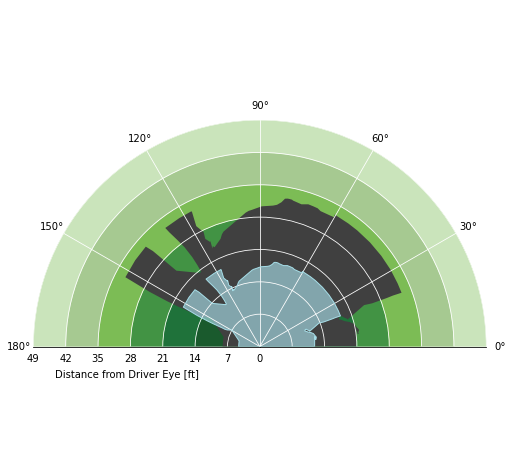

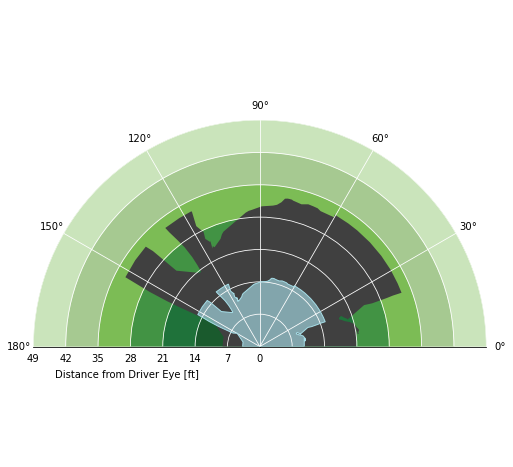

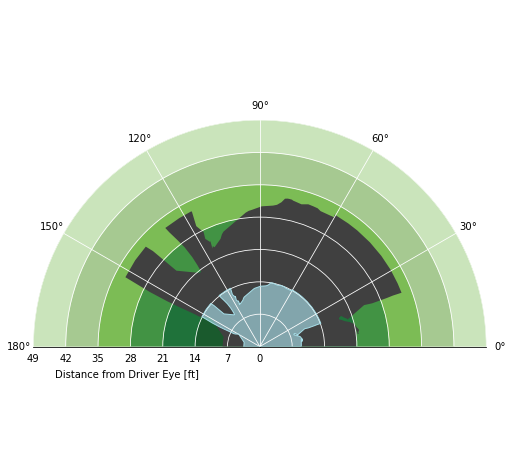

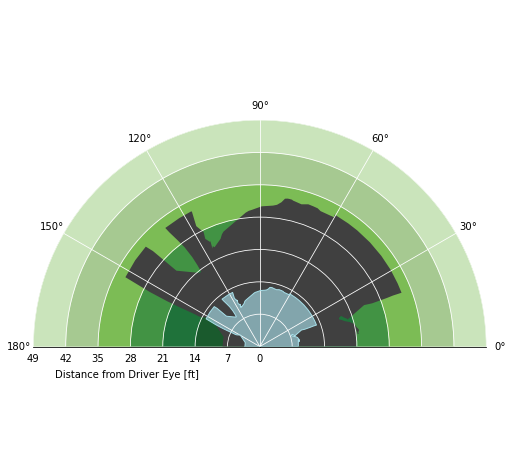

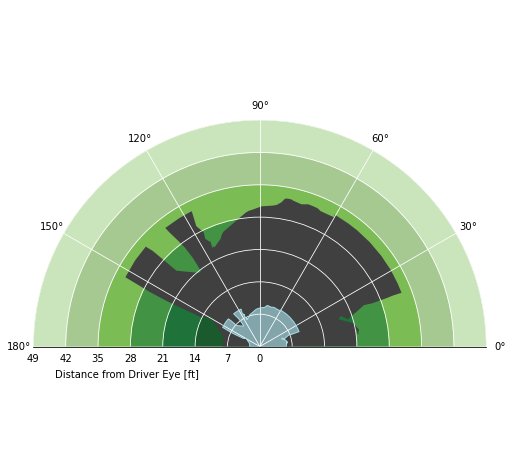

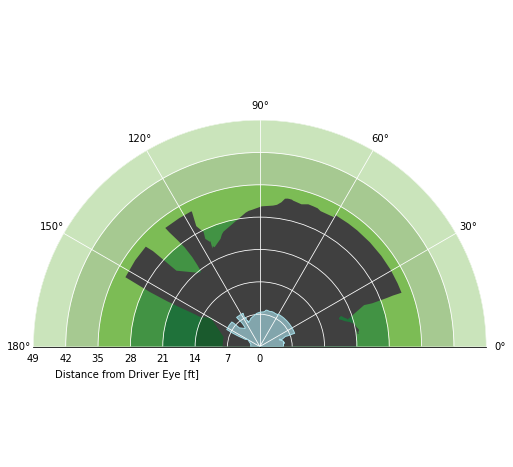

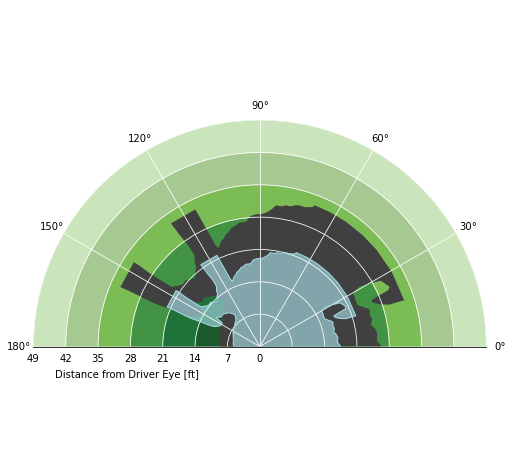

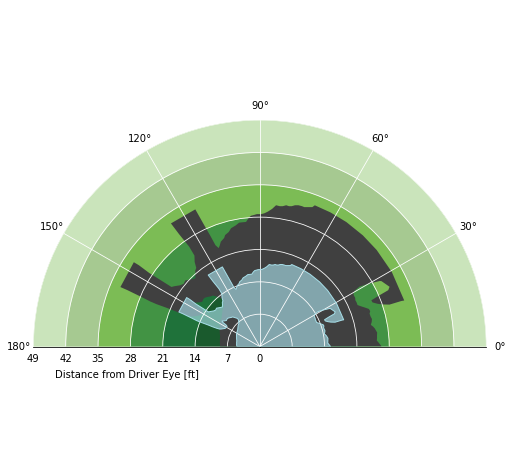

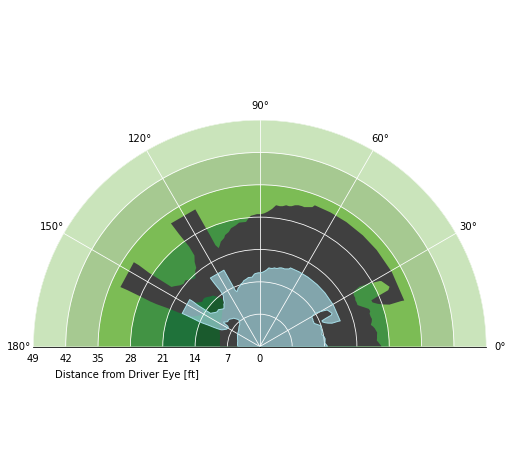

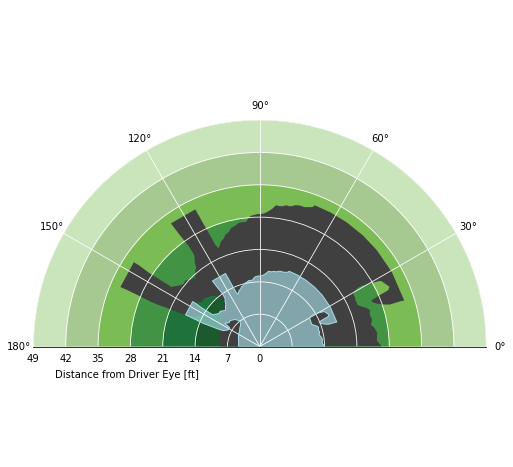

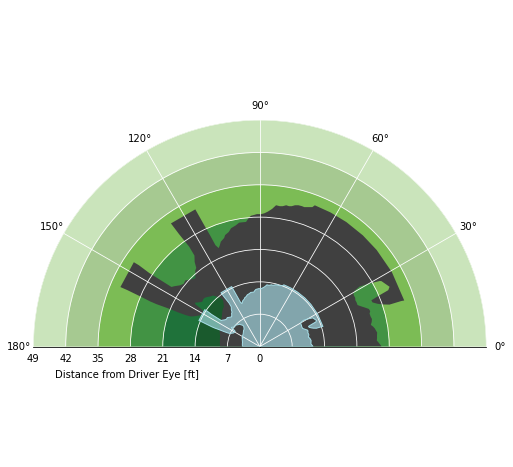

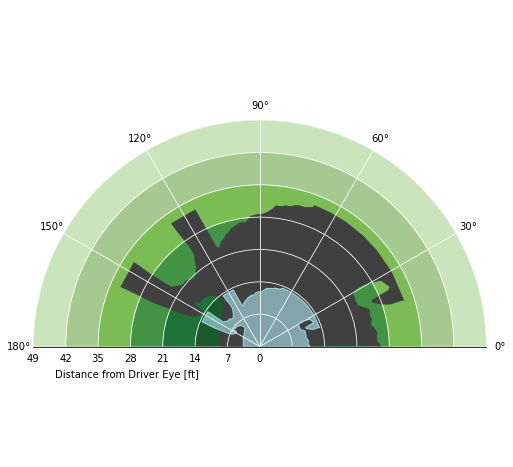

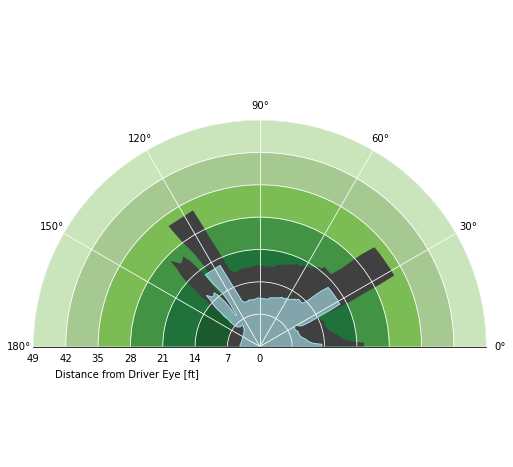

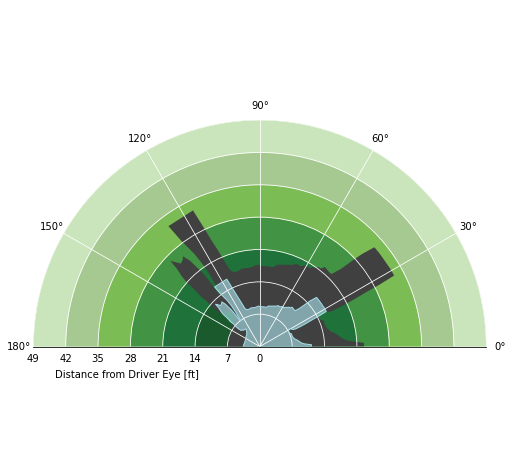

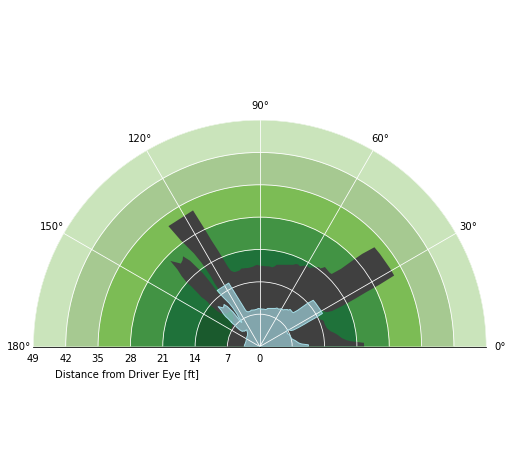

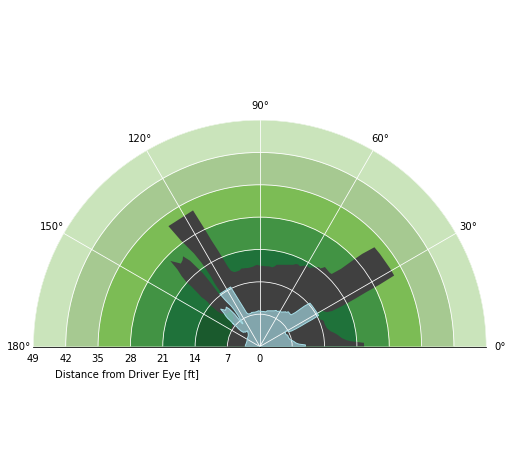

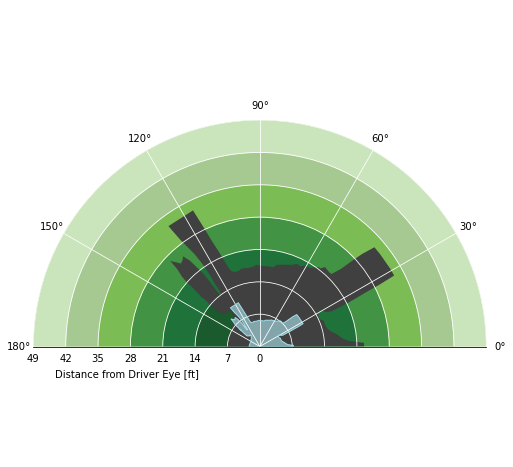

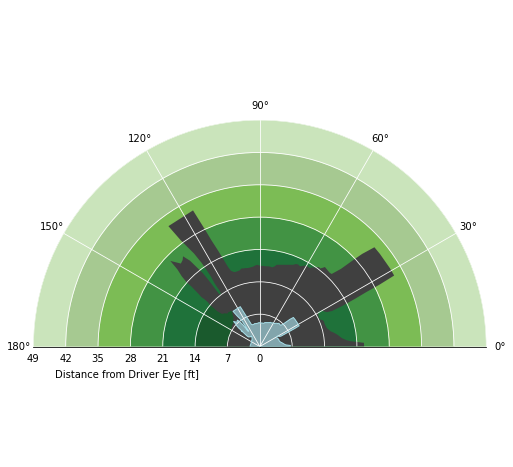

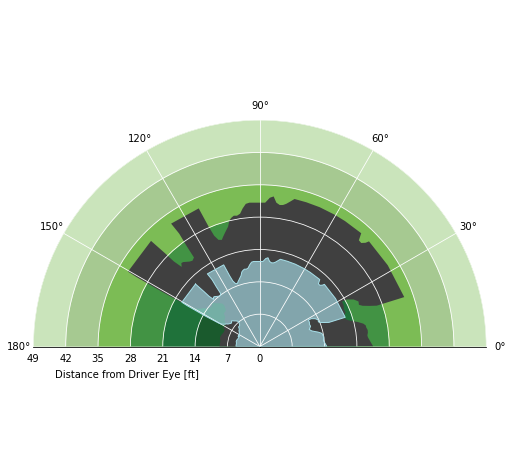

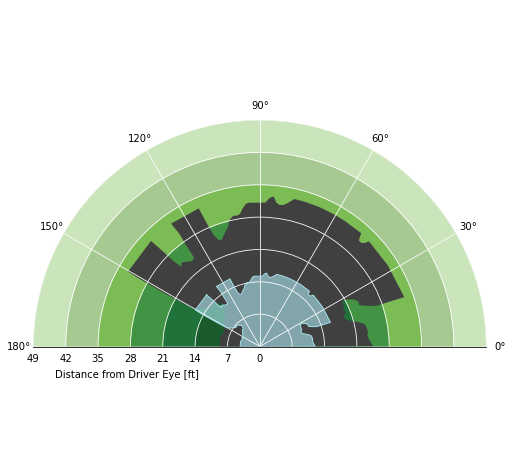

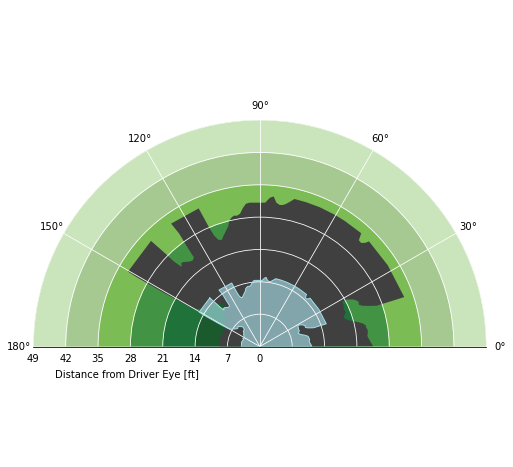

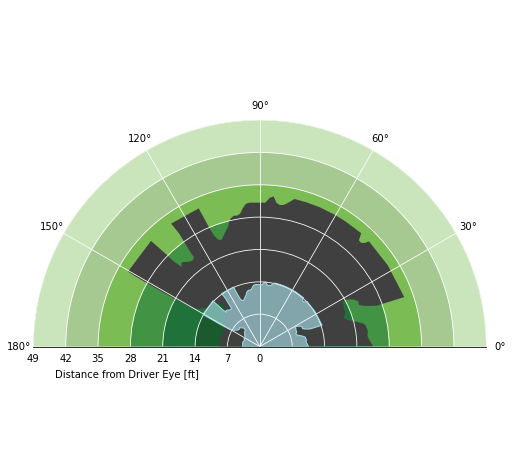

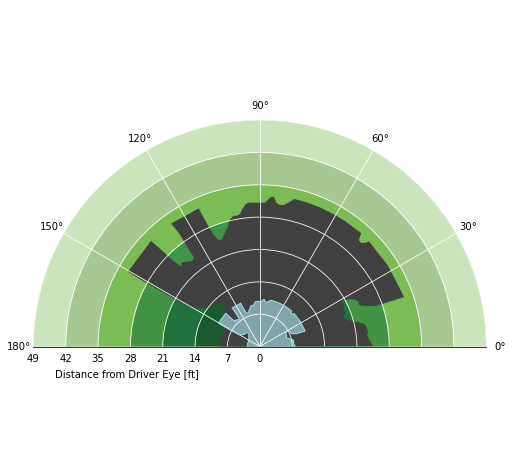

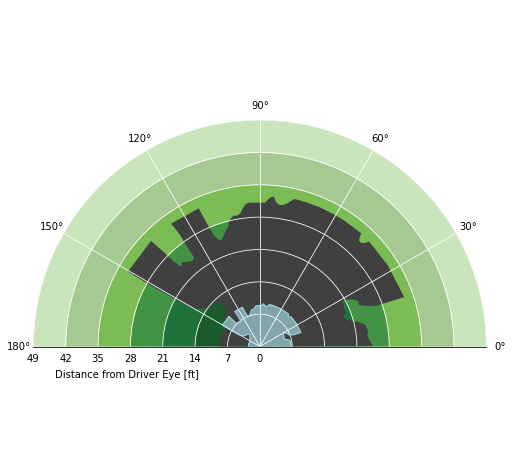

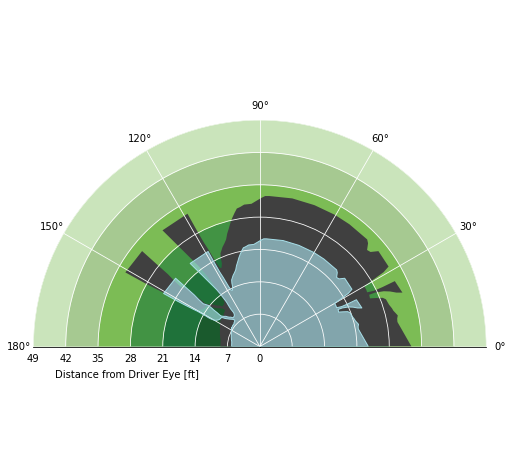

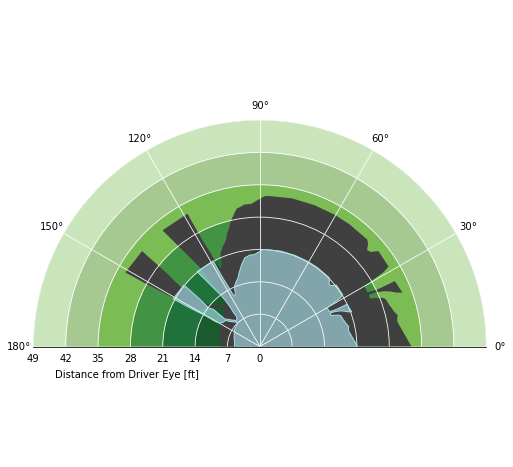

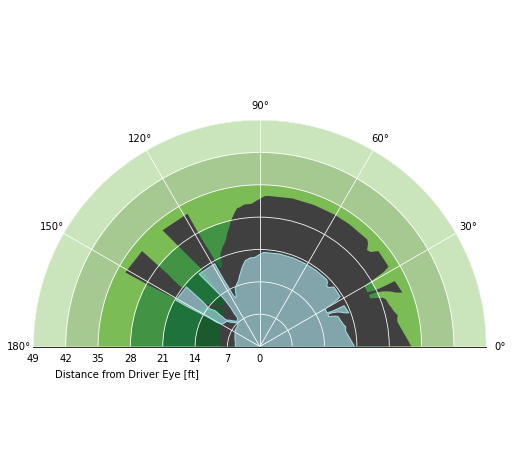

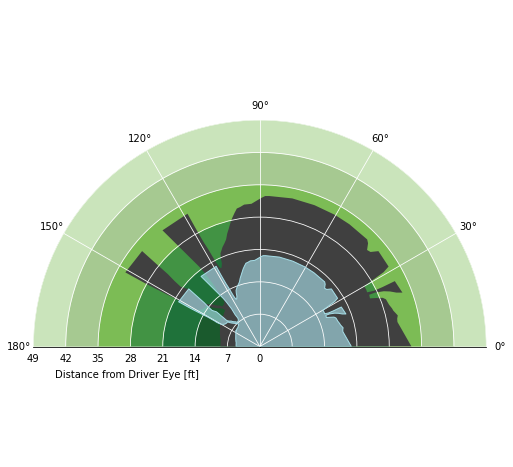

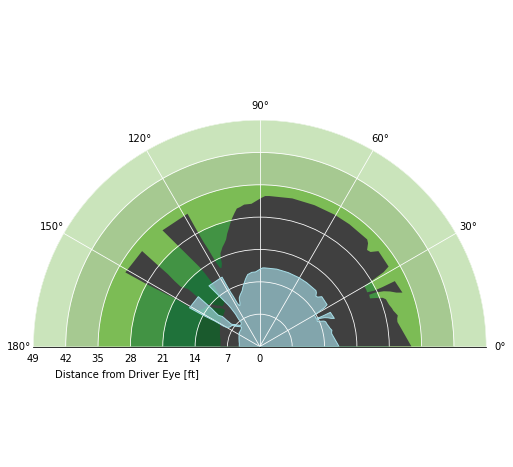

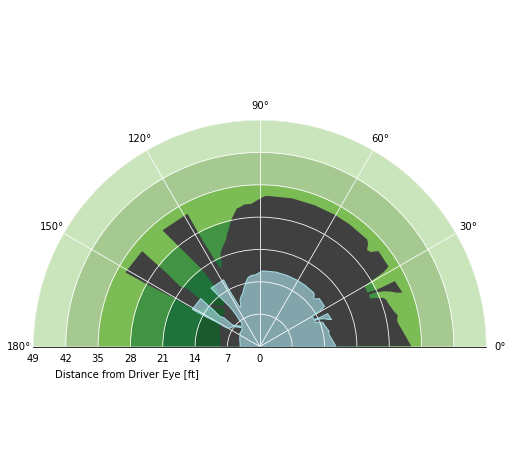

In [35]:
# loop through markerless data, join with shapefiles
for x in markerless_data['FileName_10m']:
    #only want entries with a fiel name
    if str(x) != "nan":
        #replace with your file path
        datafile = r"C:\Users\Eric.Englin\DOT OST\VIEW - MassDOT\Data Collection\shapefiles/" + x + ".shp"
        print(datafile)
        
        #read shapefile, save lat/lon into pandas df
        data = gpd.read_file(datafile)
        poly_mapped = mapping(data)
        poly_coordinates = poly_mapped['features'][0]['geometry']['coordinates'][0]
        lats = [coords[1] for coords in poly_coordinates]
        lons = [coords[0] for coords in poly_coordinates]
        df = pd.DataFrame({
            'lat':lats,
            'lon':lons})
        
        #filter dataset for other values
        this_vehicle = markerless_data.loc[markerless_data['FileName_10m']==x]        
        eye_height_full = this_vehicle["z"].values[0]/100
        eye_point_full =  this_vehicle["y"].values[0]/100 #y
        vru_selected=[1,3]
        vehicle_width =  this_vehicle["x"].values[0]/100 +  this_vehicle["Eyepoint to pass side window (cm)"].values[0]/100 #eyepoint to pass window + x
        vehicle_D = 1
        
        #run overhead_viz
        preschool_child_distance_front,preschool_child_distance_passenger, preschool_child_count = viz_overhead(df.lon*100, df.lat*100, eye_height_full, 
                         eye_point_full, [1], vehicle_width, vehicle_D, dist_to_passenger_window)

        elem_biker_distance_front,elem_biker_distance_passenger, elem_biker_count = viz_overhead(df.lon*100, df.lat*100, eye_height_full, 
                 eye_point_full, [2], vehicle_width, vehicle_D, dist_to_passenger_window)

        elementary_child_distance_front,elementary_child_distance_passenger, elementary_child_count = viz_overhead(df.lon*100, df.lat*100, eye_height_full, 
                 eye_point_full, [3], vehicle_width, vehicle_D, dist_to_passenger_window)
        
        wheelchair_user_distance_front,wheelchair_user_distance_passenger, wheelchair_user_count = viz_overhead(df.lon*100, df.lat*100, eye_height_full, 
                 eye_point_full, [4], vehicle_width, vehicle_D, dist_to_passenger_window)
        
        adult_biker_distance_front,adult_biker_distance_passenger, adult_biker_count = viz_overhead(df.lon*100, df.lat*100, eye_height_full, 
                 eye_point_full, [5], vehicle_width, vehicle_D, dist_to_passenger_window)

        adult_distance_front,adult_distance_passenger, adult_count = viz_overhead(df.lon*100, df.lat*100, eye_height_full, 
         eye_point_full, [6], vehicle_width, vehicle_D, dist_to_passenger_window)
        
        markerless_data.loc[markerless_data['FileName_10m']==x, "Forward distance to preschool child"]=preschool_child_distance_front
        markerless_data.loc[markerless_data['FileName_10m']==x, "Forward distance to elementary school child"]=elementary_child_distance_front
        markerless_data.loc[markerless_data['FileName_10m']==x, "Forward distance to adult"]=adult_distance_front
        markerless_data.loc[markerless_data['FileName_10m']==x, "Forward distance to wheelchair user"]=wheelchair_user_distance_front
        markerless_data.loc[markerless_data['FileName_10m']==x, "Passenger distance to elementary school biker"]=elem_biker_distance_passenger
        markerless_data.loc[markerless_data['FileName_10m']==x, "Passenger distance to adult biker"]=adult_biker_distance_passenger
        markerless_data.loc[markerless_data['FileName_10m']==x, "# Preschool children in blind zone"]=preschool_child_count
        markerless_data.loc[markerless_data['FileName_10m']==x, "# elem school children in blind zone"]=elementary_child_count
        markerless_data.loc[markerless_data['FileName_10m']==x, "# adults in blind zone"]=adult_count
        markerless_data.loc[markerless_data['FileName_10m']==x, "# wheelchair users in blind zone"]=wheelchair_user_count
        markerless_data.loc[markerless_data['FileName_10m']==x, "# elementary school bikers in blind zone"]=elem_biker_count
        markerless_data.loc[markerless_data['FileName_10m']==x, "# adult bikers in blind zone"]=adult_biker_count


In [ ]:
markerless_data.to_excel(file_path + "MassDOT Markerless data_results_python.xlsx")